# Neural Networks

Neural networks being a very powerful class of models, especially in cases where the learning of representations from low-level information (such as pixels, audio samples or text) is key, sensAI provides many useful abstractions for dealing with this class of models, facilitating data handling, learning and evaluation.

sensAI mainly provides abstractions for PyTorch, but there is also rudimentary support for TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.extend(["../src", ".."])
import sensai
import pandas as pd
import numpy as np
from typing import *
import config
import warnings
import functools

cfg = config.get_config()
warnings.filterwarnings("ignore")
sensai.util.logging.configure()

## Image Classification

As an example use case, let us solve the classification problem of classifying digits in pixel images from the MNIST dataset. Images are greyscale (no colour information) and 28x28 pixels in size.

In [3]:
mnist_df = pd.read_csv(cfg.datafile_path("mnist_train.csv.zip"))

The data frame contains one column for every pixel, each pixel being represented by an 8-bit integer (0 to 255).

In [4]:
mnist_df.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's create the I/O data for our experiments.

In [5]:
mnistIoData = sensai.InputOutputData.from_data_frame(mnist_df, "label")

Now that we have the image data separated from the labels, let's write a function to restore the 2D image arrays and take a look at some of the images.

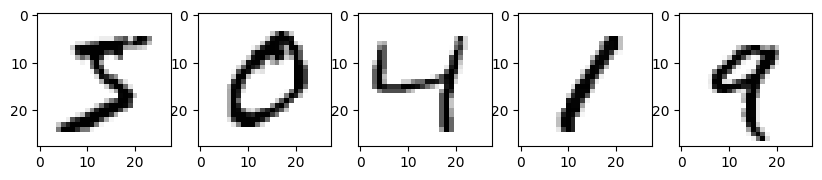

In [6]:
import matplotlib.pyplot as plt

def reshape_2d_image(series):
    return series.values.reshape(28, 28)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
for i in range(5):
    axs[i].imshow(reshape_2d_image(mnistIoData.inputs.iloc[i]), cmap="binary")

### Applying Predefined Models



We create an evaluator in order to test the performance of our models, randomly splitting the data.

In [7]:
evaluator_params = sensai.evaluation.ClassificationEvaluatorParams(fractional_split_test_fraction=0.2)
eval_util = sensai.evaluation.ClassificationModelEvaluation(mnistIoData, evaluator_params=evaluator_params)

One pre-defined model we could try is a simple multi-layer perceptron. A PyTorch-based implementation is provided via class `MultiLayerPerceptronVectorClassificationModel`. This implementation supports CUDA-accelerated computations (on Nvidia GPUs), yet we shall stick to CPU-based computation (cuda=False) in this tutorial.

In [8]:
import sensai.torch

nn_optimiser_params = sensai.torch.NNOptimiserParams(early_stopping_epochs=2, batch_size=54)
torch_mlp_model = sensai.torch.models.MultiLayerPerceptronVectorClassificationModel(hidden_dims=(50, 20),
        cuda=False, normalisation_mode=sensai.torch.NormalisationMode.MAX_ALL,
        nn_optimiser_params=nn_optimiser_params, p_dropout=0.0) \
    .with_name("MLP")

Neural networks work best on **normalised inputs**, so we have opted to apply basic normalisation by specifying a normalisation mode which will transforms inputs by dividing by the maximum value found across all columns in the training data. For more elaborate normalisation options, we could have used a data frame transformer (DFT), particularly `DFTNormalisation` or `DFTSkLearnTransformer`.

sensAI's default **neural network training algorithm** is based on early stopping, which involves checking, in regular intervals, the performance of the model on a validation set (which is split from the training set) and ultimately selecting the model that performed best on the validation set. You have full control over the loss evaluation method used to select the best model (by passing a respective `NNLossEvaluator` instance to NNOptimiserParams) as well as the method that is used to split the training set into the actual training set and the validation set (by adding a `DataFrameSplitter` to the model or using a custom `TorchDataSetProvider`).

Given the vectorised nature of our MNIST dataset, we can apply any type of model which can accept the numeric inputs. Let's compare the neural network we defined above against another pre-defined model, which is based on a scikit-learn implementation and uses decision trees rather than neural networks.

In [9]:
random_forest_model = sensai.sklearn.classification.SkLearnRandomForestVectorClassificationModel(
        min_samples_leaf=1,
        n_estimators=10) \
    .with_name("RandomForest")

Let's compare the two models using our evaluation utility.

INFO  2024-06-11 09:29:37,395 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 1/2 named 'RandomForest' ...


DEBUG 2024-06-11 09:29:37,619 sensai.evaluation.evaluator:__init__:182 - <sensai.data.DataSplitterFractional object at 0x7fe227050750> created split with 48000 (80.00%) and 12000 (20.00%) training and test data points respectively


INFO  2024-06-11 09:29:37,620 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating SkLearnRandomForestVectorClassificationModel[featureGenerator=None, fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, modelConstructor=RandomForestClassifier(random_state=42, min_samples_leaf=1, n_estimators=10)] via <sensai.evaluation.evaluator.VectorClassificationModelEvaluator object at 0x7fe2270b6150>


INFO  2024-06-11 09:29:37,620 sensai.vector_model:fit:371 - Fitting SkLearnRandomForestVectorClassificationModel instance


DEBUG 2024-06-11 09:29:37,651 sensai.vector_model:fit:394 - Fitting with outputs[1]=['label'], inputs[784]=[1x1/int64, 1x2/int64, 1x3/int64, 1x4/int64, 1x5/int64, 1x6/int64, 1x7/int64, 1x8/int64, 1x9/int64, 1x10/int64, 1x11/int64, 1x12/int64, 1x13/int64, 1x14/int64, 1x15/int64, 1x16/int64, 1x17/int64, 1x18/int64, 1x19/int64, 1x20/int64, 1x21/int64, 1x22/int64, 1x23/int64, 1x24/int64, 1x25/int64, 1x26/int64, 1x27/int64, 1x28/int64, 2x1/int64, 2x2/int64, 2x3/int64, 2x4/int64, 2x5/int64, 2x6/int64, 2x7/int64, 2x8/int64, 2x9/int64, 2x10/int64, 2x11/int64, 2x12/int64, 2x13/int64, 2x14/int64, 2x15/int64, 2x16/int64, 2x17/int64, 2x18/int64, 2x19/int64, 2x20/int64, 2x21/int64, 2x22/int64, 2x23/int64, 2x24/int64, 2x25/int64, 2x26/int64, 2x27/int64, 2x28/int64, 3x1/int64, 3x2/int64, 3x3/int64, 3x4/int64, 3x5/int64, 3x6/int64, 3x7/int64, 3x8/int64, 3x9/int64, 3x10/int64, 3x11/int64, 3x12/int64, 3x13/int64, 3x14/int64, 3x15/int64, 3x16/int64, 3x17/int64, 3x18/int64, 3x19/int64, 3x20/int64, 3x21/in

INFO  2024-06-11 09:29:37,652 sensai.sklearn.sklearn_base:_fit_classifier:281 - Fitting sklearn classifier of type RandomForestClassifier


INFO  2024-06-11 09:29:40,498 sensai.vector_model:fit:400 - Fitting completed in 2.88 seconds: SkLearnRandomForestVectorClassificationModel[featureGenerator=None, fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)]


INFO  2024-06-11 09:29:40,585 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.9466666666666667, balancedAccuracy=0.945916926388699, N=12000]


INFO  2024-06-11 09:29:40,859 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 2/2 named 'MLP' ...


INFO  2024-06-11 09:29:40,860 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating MultiLayerPerceptronVectorClassificationModel[hidden_dims=(50, 20), hid_activation_function=<built-in method sigmoid of type object at 0x7fe1c8188880>, output_activation_function=ActivationFunction.LOG_SOFTMAX, input_dim=None, cuda=False, p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=Method[_create_torch_model], normalisationMode=NormalisationMode.MAX_ALL, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=54, optimiser_lr=0.001, shrinkage_clip=10.0, optimiser=adam, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=2, shuffle=True], model=None, inputTensoriser=None, outputTensoriser=None, torchDataSetProviderFactory=None, dataFrameSplitter=None, name=MLP] via <sensai.evaluation.evaluato

INFO  2024-06-11 09:29:40,861 sensai.vector_model:fit:371 - Fitting MultiLayerPerceptronVectorClassificationModel instance


DEBUG 2024-06-11 09:29:40,870 sensai.vector_model:fit:394 - Fitting with outputs[1]=['label'], inputs[784]=[1x1/int64, 1x2/int64, 1x3/int64, 1x4/int64, 1x5/int64, 1x6/int64, 1x7/int64, 1x8/int64, 1x9/int64, 1x10/int64, 1x11/int64, 1x12/int64, 1x13/int64, 1x14/int64, 1x15/int64, 1x16/int64, 1x17/int64, 1x18/int64, 1x19/int64, 1x20/int64, 1x21/int64, 1x22/int64, 1x23/int64, 1x24/int64, 1x25/int64, 1x26/int64, 1x27/int64, 1x28/int64, 2x1/int64, 2x2/int64, 2x3/int64, 2x4/int64, 2x5/int64, 2x6/int64, 2x7/int64, 2x8/int64, 2x9/int64, 2x10/int64, 2x11/int64, 2x12/int64, 2x13/int64, 2x14/int64, 2x15/int64, 2x16/int64, 2x17/int64, 2x18/int64, 2x19/int64, 2x20/int64, 2x21/int64, 2x22/int64, 2x23/int64, 2x24/int64, 2x25/int64, 2x26/int64, 2x27/int64, 2x28/int64, 3x1/int64, 3x2/int64, 3x3/int64, 3x4/int64, 3x5/int64, 3x6/int64, 3x7/int64, 3x8/int64, 3x9/int64, 3x10/int64, 3x11/int64, 3x12/int64, 3x13/int64, 3x14/int64, 3x15/int64, 3x16/int64, 3x17/int64, 3x18/int64, 3x19/int64, 3x20/int64, 3x21/in

INFO  2024-06-11 09:29:41,046 sensai.torch.torch_opt.NNOptimiser:fit:682 - Preparing parameter learning of MultiLayerPerceptronTorchModel[cuda=False, inputDim=784, outputDim=10, hidActivationFunction=<built-in method sigmoid of type object at 0x7fe1c8188880>, outputActivationFunction=functools.partial(<function log_softmax at 0x7fe22611a9e0>, dim=1), hiddenDims=(50, 20), pDropout=0.0, overrideInputDim=None, bestEpoch=None, totalEpochs=None] via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=54, optimiser_lr=0.001, shrinkage_clip=10.0, optimiser=adam, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=2, shuffle=True]] with cuda=False


INFO  2024-06-11 09:29:41,048 sensai.torch.torch_opt.NNOptimiser:fit:716 - Obtaining input/output training instances


INFO  2024-06-11 09:29:41,228 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Data set 1/1: #train=36000, #validation=12000


INFO  2024-06-11 09:29:41,229 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of validation sets: 1


INFO  2024-06-11 09:29:41,231 sensai.torch.torch_opt.NNOptimiser:fit:746 - Learning parameters of MultiLayerPerceptronTorchModel[cuda=False, inputDim=784, outputDim=10, hidActivationFunction=<built-in method sigmoid of type object at 0x7fe1c8188880>, outputActivationFunction=functools.partial(<function log_softmax at 0x7fe22611a9e0>, dim=1), hiddenDims=(50, 20), pDropout=0.0, overrideInputDim=None, bestEpoch=None, totalEpochs=None]


INFO  2024-06-11 09:29:41,232 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of parameters: 40480


INFO  2024-06-11 09:29:41,232 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Starting training process via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=54, optimiser_lr=0.001, shrinkage_clip=10.0, optimiser=adam, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=2, shuffle=True]]


INFO  2024-06-11 09:29:41,242 sensai.torch.torch_opt.NNOptimiser:fit:764 - Begin training with cuda=False


INFO  2024-06-11 09:29:41,242 sensai.torch.torch_opt.NNOptimiser:fit:765 - Press Ctrl+C to end training early


INFO  2024-06-11 09:29:42,418 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   1/1000 completed in  1.18s | train loss 1.4059 | validation NLL 0.7300 | best NLL 0.730044 from this epoch


INFO  2024-06-11 09:29:43,557 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   2/1000 completed in  1.13s | train loss 0.5021 | validation NLL 0.3806 | best NLL 0.380582 from this epoch


INFO  2024-06-11 09:29:44,756 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   3/1000 completed in  1.19s | train loss 0.3138 | validation NLL 0.2847 | best NLL 0.284687 from this epoch


INFO  2024-06-11 09:29:45,946 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   4/1000 completed in  1.18s | train loss 0.2409 | validation NLL 0.2393 | best NLL 0.239259 from this epoch


INFO  2024-06-11 09:29:47,124 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   5/1000 completed in  1.17s | train loss 0.1981 | validation NLL 0.2081 | best NLL 0.208118 from this epoch


INFO  2024-06-11 09:29:48,276 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   6/1000 completed in  1.14s | train loss 0.1676 | validation NLL 0.1872 | best NLL 0.187202 from this epoch


INFO  2024-06-11 09:29:49,294 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   7/1000 completed in  1.01s | train loss 0.1450 | validation NLL 0.1697 | best NLL 0.169709 from this epoch


INFO  2024-06-11 09:29:50,309 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   8/1000 completed in  1.01s | train loss 0.1274 | validation NLL 0.1593 | best NLL 0.159322 from this epoch


INFO  2024-06-11 09:29:51,326 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   9/1000 completed in  1.01s | train loss 0.1131 | validation NLL 0.1509 | best NLL 0.150902 from this epoch


INFO  2024-06-11 09:29:52,344 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  10/1000 completed in  1.01s | train loss 0.1013 | validation NLL 0.1440 | best NLL 0.144011 from this epoch


INFO  2024-06-11 09:29:53,363 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  11/1000 completed in  1.01s | train loss 0.0906 | validation NLL 0.1381 | best NLL 0.138148 from this epoch


INFO  2024-06-11 09:29:54,383 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  12/1000 completed in  1.01s | train loss 0.0816 | validation NLL 0.1334 | best NLL 0.133373 from this epoch


INFO  2024-06-11 09:29:55,400 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  13/1000 completed in  1.01s | train loss 0.0739 | validation NLL 0.1315 | best NLL 0.131459 from this epoch


INFO  2024-06-11 09:29:56,417 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  14/1000 completed in  1.01s | train loss 0.0667 | validation NLL 0.1281 | best NLL 0.128110 from this epoch


INFO  2024-06-11 09:29:57,436 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  15/1000 completed in  1.01s | train loss 0.0610 | validation NLL 0.1271 | best NLL 0.127124 from this epoch


INFO  2024-06-11 09:29:58,599 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  16/1000 completed in  1.16s | train loss 0.0553 | validation NLL 0.1222 | best NLL 0.122218 from this epoch


INFO  2024-06-11 09:29:59,777 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  17/1000 completed in  1.17s | train loss 0.0504 | validation NLL 0.1258 | best NLL 0.122218 from epoch 16


INFO  2024-06-11 09:30:00,944 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch  18/1000 completed in  1.17s | train loss 0.0461 | validation NLL 0.1233 | best NLL 0.122218 from epoch 16


INFO  2024-06-11 09:30:00,945 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Stopping early: 2 epochs without validation metric improvement


INFO  2024-06-11 09:30:00,945 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Training complete


INFO  2024-06-11 09:30:00,946 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Best model is from epoch 16 with NLL 0.12221813999116421 on validation set


INFO  2024-06-11 09:30:00,954 sensai.vector_model:fit:400 - Fitting completed in 20.09 seconds: MultiLayerPerceptronVectorClassificationModel[hidden_dims=(50, 20), hid_activation_function=<built-in method sigmoid of type object at 0x7fe1c8188880>, output_activation_function=ActivationFunction.LOG_SOFTMAX, input_dim=None, cuda=False, p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=Method[_create_torch_model], normalisationMode=NormalisationMode.MAX_ALL, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=54, optimiser_lr=0.001, shrinkage_clip=10.0, optimiser=adam, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=2, shuffle=True], model=MultiLayerPerceptronTorchModel[cuda=False, inputDim=784, outputDim=10, hidActivationFunction=<built-in method sigmoid of type object at 0x7fe1c8188880>, ou

DEBUG 2024-06-11 09:30:00,955 sensai.torch.torch_data:__init__:546 - Applying <sensai.torch.torch_data.TensoriserDataFrameFloatValuesMatrix object at 0x7fe2248c8f50> to data frame of length 12000 ...


INFO  2024-06-11 09:30:01,085 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.96225, balancedAccuracy=0.9618968610010363, N=12000]


INFO  2024-06-11 09:30:01,410 sensai.evaluation.eval_util:compare_models:462 - Model comparison results:
              accuracy  balancedAccuracy
model_name                              
RandomForest  0.946667          0.945917
MLP           0.962250          0.961897


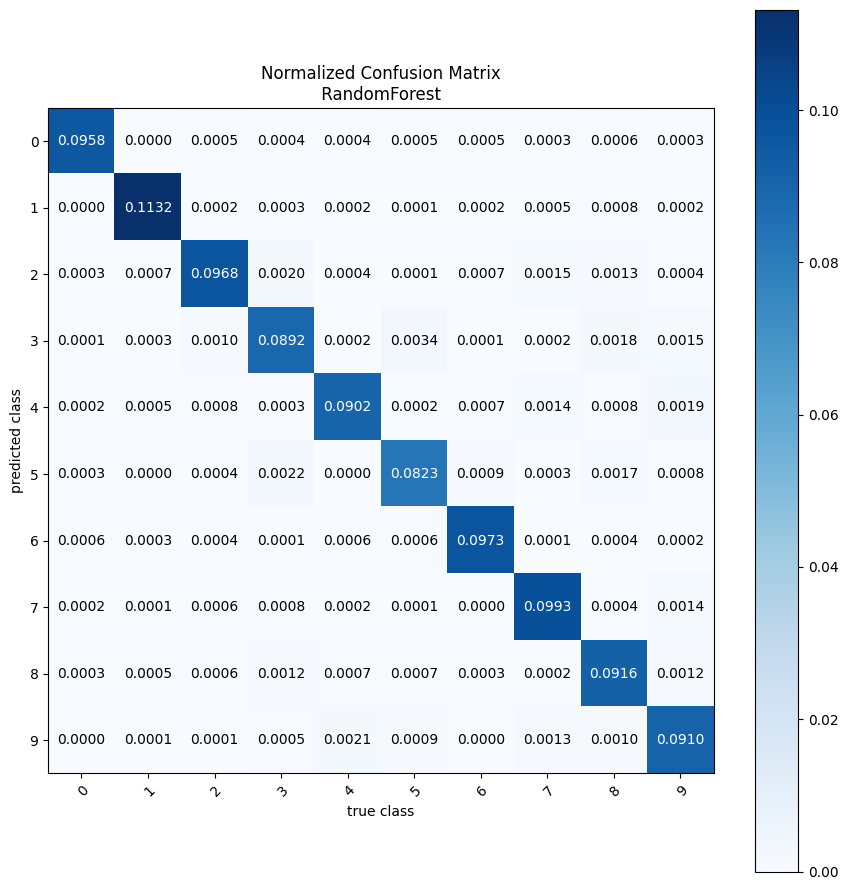

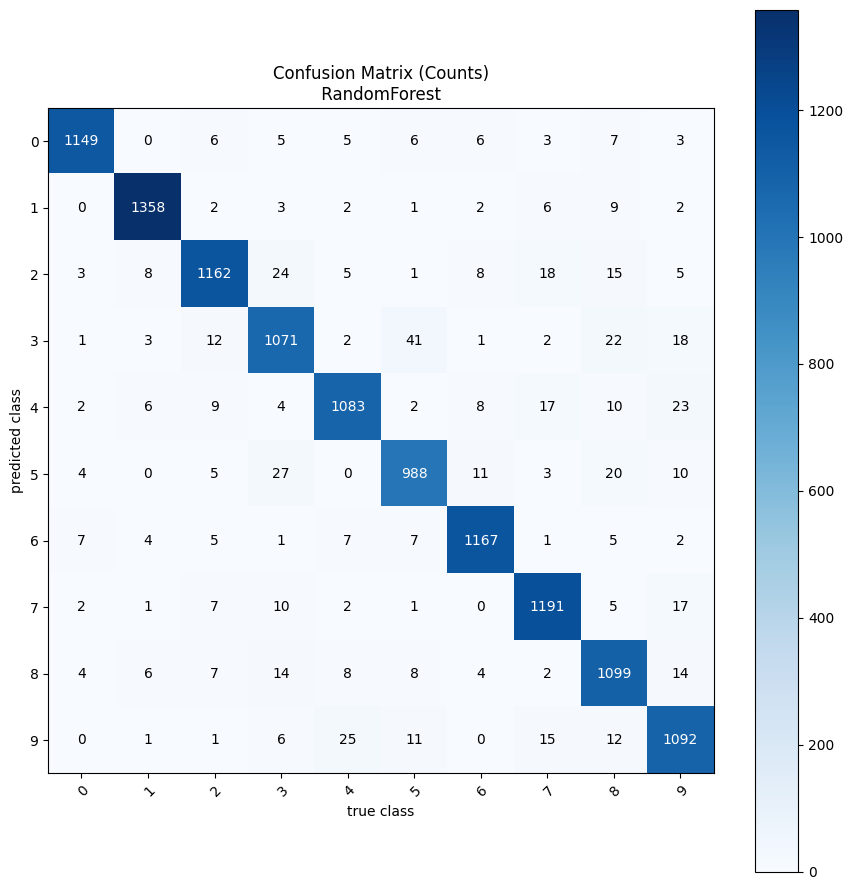

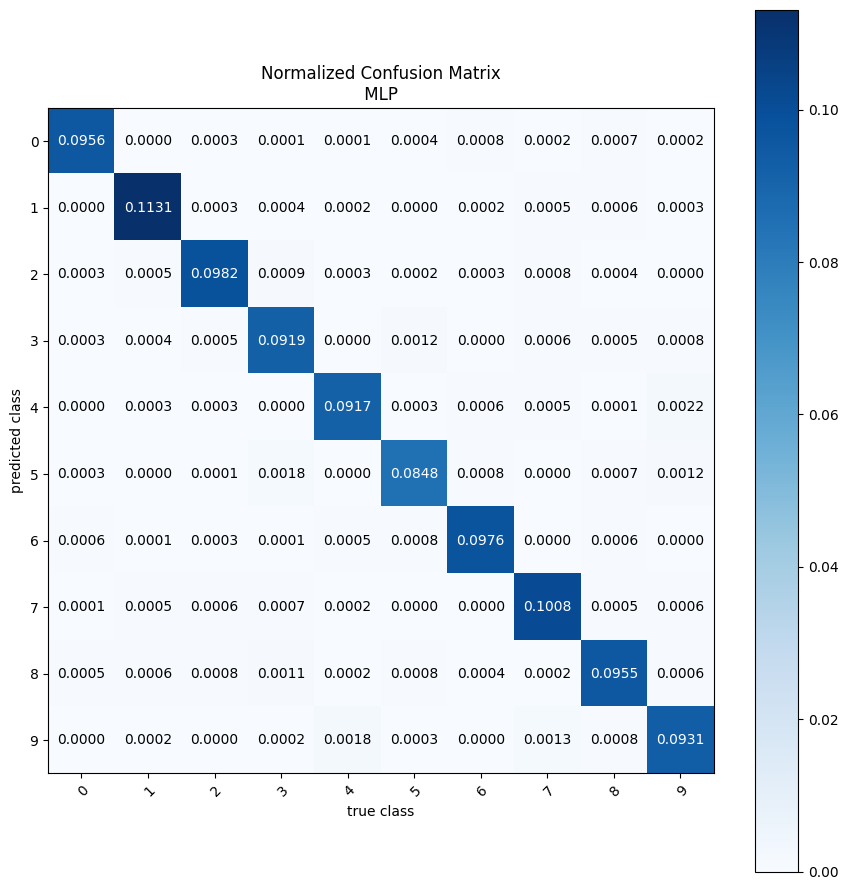

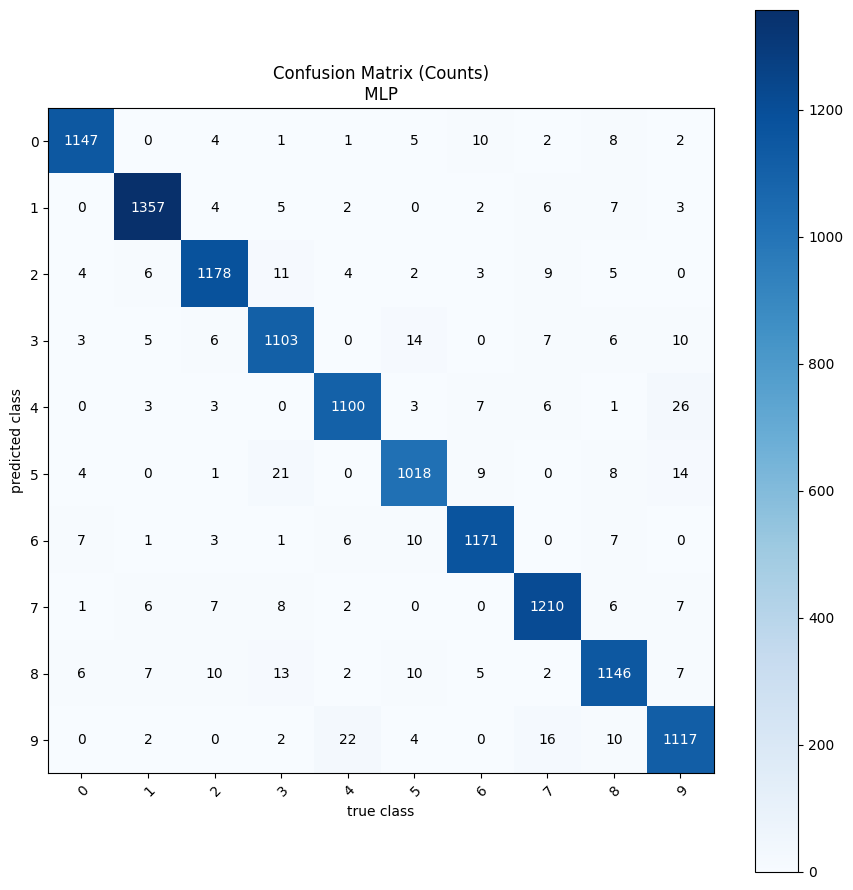

In [10]:
eval_util.compare_models([random_forest_model, torch_mlp_model])

Both models perform reasonably well.

### Creating a Custom CNN Model

Given that this is an image recognition problem, it can be sensible to apply convolutional neural networks (CNNs), which can analyse patches of the image in order to generate more high-level features from them.
Specifically, we shall apply a neural network model which uses multiple convolutions, a max-pooling layer and a multi-layer perceptron at the end in order to produce the classification.

For classification and regression, sensAI provides the fundamental classes `TorchVectorClassificationModel` and `TorchVectorRegressionModel` respectively. Ultimately, these classes will wrap an instance of `torch.nn.Module`, the base class for neural networks in PyTorch.

#### Wrapping a Custom torch.nn.Module Instance

If we already had an implementation of a `torch.nn.Module`, it can be straightforwardly adapted to become a sensAI ``VectorModel``.

Let's say we had the following implementation of a torch module, which performs the steps described above.


In [11]:
import torch

class MnistCnnModule(torch.nn.Module):
    def __init__(self, image_dim: int, output_dim: int, num_conv: int, kernel_size: int, pooling_kernel_size: int,
            mlp_hidden_dims: Sequence[int], output_activation_fn: sensai.torch.ActivationFunction, p_dropout=0.0):
        super().__init__()
        k = kernel_size
        p = pooling_kernel_size
        self.cnn = torch.nn.Conv2d(1, num_conv, (k, k))
        self.pool = torch.nn.MaxPool2d((p, p))
        self.dropout = torch.nn.Dropout(p=p_dropout)
        reduced_dim = (image_dim - k + 1) / p
        if int(reduced_dim) != reduced_dim:
            raise ValueError(f"Pooling kernel size {p} is not a divisor of post-convolution dimension {image_dim - k + 1}")
        self.mlp = sensai.torch.models.MultiLayerPerceptron(num_conv * int(reduced_dim) ** 2, output_dim, mlp_hidden_dims,
            output_activation_fn=output_activation_fn.get_torch_function(),
            hid_activation_fn=sensai.torch.ActivationFunction.RELU.get_torch_function(),
            p_dropout=p_dropout)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        return self.mlp(x)

Since this module requires 2D images as input, we will need a component that transforms the vector input that is given in our data frame into a tensor that will serve as input to the module.
In sensAI, the abstraction for this purpose is a ``sensai.torch.Tensoriser``. A **Tensoriser** can, in principle, perform arbitrary computations in order to produce, from a data frame with N rows, one or more tensors of length N (first dimension equal to N) that will ultimately be fed to the neural network.

Luckily, for the case at hand, we already have the function ``reshape_2d_image`` from above to assist in the implementation of the tensoriser.

In [12]:
class ImageReshapingInputTensoriser(sensai.torch.RuleBasedTensoriser):
    def _tensorise(self, df: pd.DataFrame) -> Union[torch.Tensor, List[torch.Tensor]]:
        images = [reshape_2d_image(row) for _, row in df.iterrows()]
        return torch.tensor(np.stack(images)).float() / 255

In this case, we derived the class from ``RuleBasedTensoriser`` rather than ``Tensoriser``, because our tensoriser does not require fitting. We additionally took care of the normalisation.

Now we have all we need to create a sensAI ``TorchVectorClassificationModel`` that will work on the input/output data we loaded earlier.

In [13]:
cnn_module = MnistCnnModule(28, 10, 32, 5, 2, (200, 20), sensai.torch.ActivationFunction.LOG_SOFTMAX)
nn_optimiser_params = sensai.torch.NNOptimiserParams(
    optimiser=sensai.torch.Optimiser.ADAMW,
    optimiser_lr=0.01,
    batch_size=1024,
    early_stopping_epochs=3)
cnn_model_from_module = sensai.torch.TorchVectorClassificationModel.from_module(
        cnn_module, sensai.torch.ClassificationOutputMode.LOG_PROBABILITIES,
        cuda=False, nn_optimiser_params=nn_optimiser_params) \
    .with_input_tensoriser(ImageReshapingInputTensoriser()) \
    .with_name("CNN")

We have now fully defined all the necessary parameters, including parameters controlling the training of the model.

We are now ready to evaluate the model.

DEBUG 2024-06-11 09:30:03,401 sensai.evaluation.evaluator:__init__:182 - <sensai.data.DataSplitterFractional object at 0x7fe227050750> created split with 48000 (80.00%) and 12000 (20.00%) training and test data points respectively


INFO  2024-06-11 09:30:03,402 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating TorchVectorClassificationModel[featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=<sensai.torch.torch_base.TorchModelFactoryFromModule object at 0x7fe224909610>, normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True], model=None, inputTensoriser=<__main__.ImageReshapingInputTensoriser object at 0x7fe223249450>, outputTensoriser=None, torchDataSetProviderFactory=None, dataFrameSplitter=None, name=CNN] via <sensai.evaluation.evaluator.VectorClassificationModelEvaluator object at 0x7fe223740cd0>


INFO  2024-06-11 09:30:03,402 sensai.vector_model:fit:371 - Fitting TorchVectorClassificationModel instance


DEBUG 2024-06-11 09:30:03,426 sensai.vector_model:fit:394 - Fitting with outputs[1]=['label'], inputs[784]=[1x1/int64, 1x2/int64, 1x3/int64, 1x4/int64, 1x5/int64, 1x6/int64, 1x7/int64, 1x8/int64, 1x9/int64, 1x10/int64, 1x11/int64, 1x12/int64, 1x13/int64, 1x14/int64, 1x15/int64, 1x16/int64, 1x17/int64, 1x18/int64, 1x19/int64, 1x20/int64, 1x21/int64, 1x22/int64, 1x23/int64, 1x24/int64, 1x25/int64, 1x26/int64, 1x27/int64, 1x28/int64, 2x1/int64, 2x2/int64, 2x3/int64, 2x4/int64, 2x5/int64, 2x6/int64, 2x7/int64, 2x8/int64, 2x9/int64, 2x10/int64, 2x11/int64, 2x12/int64, 2x13/int64, 2x14/int64, 2x15/int64, 2x16/int64, 2x17/int64, 2x18/int64, 2x19/int64, 2x20/int64, 2x21/int64, 2x22/int64, 2x23/int64, 2x24/int64, 2x25/int64, 2x26/int64, 2x27/int64, 2x28/int64, 3x1/int64, 3x2/int64, 3x3/int64, 3x4/int64, 3x5/int64, 3x6/int64, 3x7/int64, 3x8/int64, 3x9/int64, 3x10/int64, 3x11/int64, 3x12/int64, 3x13/int64, 3x14/int64, 3x15/int64, 3x16/int64, 3x17/int64, 3x18/int64, 3x19/int64, 3x20/int64, 3x21/in

INFO  2024-06-11 09:30:03,427 sensai.torch.torch_base:_fit_classifier:780 - Fitting <__main__.ImageReshapingInputTensoriser object at 0x7fe223249450> ...


INFO  2024-06-11 09:30:03,486 sensai.torch.torch_opt.NNOptimiser:fit:682 - Preparing parameter learning of TorchModelFromModule[cuda=False, bestEpoch=None, totalEpochs=None] via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True]] with cuda=False


INFO  2024-06-11 09:30:03,488 sensai.torch.torch_opt.NNOptimiser:fit:716 - Obtaining input/output training instances


INFO  2024-06-11 09:30:05,929 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Data set 1/1: #train=36000, #validation=12000


INFO  2024-06-11 09:30:05,930 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of validation sets: 1


INFO  2024-06-11 09:30:05,931 sensai.torch.torch_opt.NNOptimiser:fit:746 - Learning parameters of TorchModelFromModule[cuda=False, bestEpoch=None, totalEpochs=None]


INFO  2024-06-11 09:30:05,931 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of parameters: 926862


INFO  2024-06-11 09:30:05,932 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Starting training process via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True]]


INFO  2024-06-11 09:30:05,943 sensai.torch.torch_opt.NNOptimiser:fit:764 - Begin training with cuda=False


INFO  2024-06-11 09:30:05,943 sensai.torch.torch_opt.NNOptimiser:fit:765 - Press Ctrl+C to end training early


INFO  2024-06-11 09:30:16,000 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   1/1000 completed in 10.06s | train loss 0.8318 | validation NLL 0.1962 | best NLL 0.196246 from this epoch


INFO  2024-06-11 09:30:25,930 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   2/1000 completed in  9.92s | train loss 0.1365 | validation NLL 0.1341 | best NLL 0.134100 from this epoch


INFO  2024-06-11 09:30:35,948 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   3/1000 completed in 10.01s | train loss 0.0724 | validation NLL 0.1154 | best NLL 0.115383 from this epoch


INFO  2024-06-11 09:30:45,855 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   4/1000 completed in  9.90s | train loss 0.0524 | validation NLL 0.1286 | best NLL 0.115383 from epoch 3


INFO  2024-06-11 09:30:55,768 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   5/1000 completed in  9.91s | train loss 0.0418 | validation NLL 0.1073 | best NLL 0.107293 from this epoch


INFO  2024-06-11 09:31:05,693 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   6/1000 completed in  9.91s | train loss 0.0345 | validation NLL 0.0818 | best NLL 0.081762 from this epoch


INFO  2024-06-11 09:31:15,568 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   7/1000 completed in  9.86s | train loss 0.0293 | validation NLL 0.0953 | best NLL 0.081762 from epoch 6


INFO  2024-06-11 09:31:25,440 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   8/1000 completed in  9.87s | train loss 0.0245 | validation NLL 0.1157 | best NLL 0.081762 from epoch 6


INFO  2024-06-11 09:31:35,300 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   9/1000 completed in  9.86s | train loss 0.0209 | validation NLL 0.0996 | best NLL 0.081762 from epoch 6


INFO  2024-06-11 09:31:35,301 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Stopping early: 3 epochs without validation metric improvement


INFO  2024-06-11 09:31:35,302 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Training complete


INFO  2024-06-11 09:31:35,302 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Best model is from epoch 6 with NLL 0.08176225980122884 on validation set


INFO  2024-06-11 09:31:35,313 sensai.vector_model:fit:400 - Fitting completed in 91.91 seconds: TorchVectorClassificationModel[featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=<sensai.torch.torch_base.TorchModelFactoryFromModule object at 0x7fe224909610>, normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True], model=TorchModelFromModule[cuda=False, bestEpoch=6, totalEpochs=9], inputTensoriser=<__main__.ImageReshapingInputTensoriser object at 0x7fe223249450>, outputTensoriser=None, torchDataSetProviderFactory=None, dataFrameSplitter=None, name=CNN]


DEBUG 2024-06-11 09:31:35,314 sensai.torch.torch_data:__init__:546 - Applying <__main__.ImageReshapingInputTensoriser object at 0x7fe223249450> to data frame of length 12000 ...


INFO  2024-06-11 09:31:37,080 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.9784166666666667, balancedAccuracy=0.9782716826784611, N=12000]


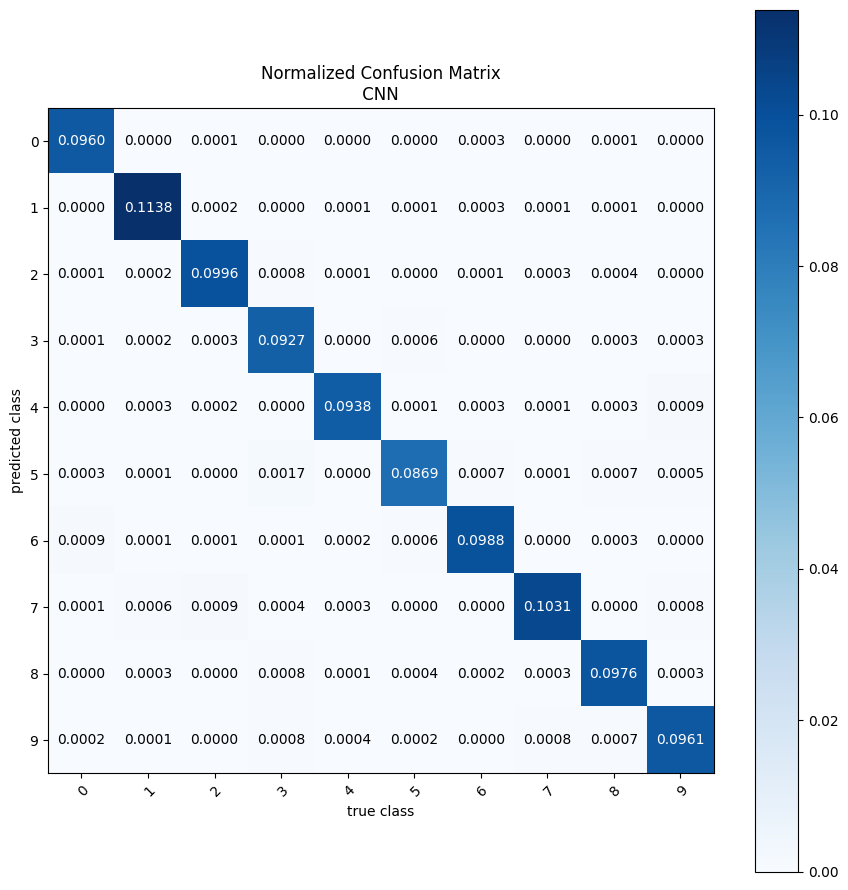

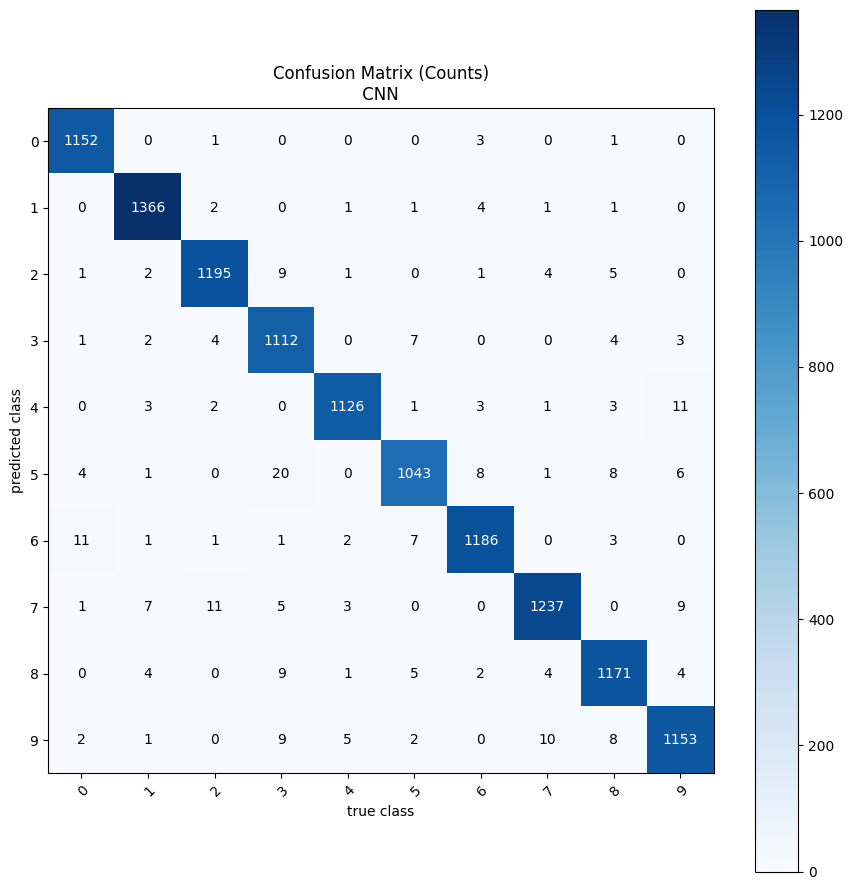

In [14]:
eval_util.perform_simple_evaluation(cnn_model_from_module);

#### Creating an Input-/Output-Adaptive Custom Model

While the above approach allows us to straightforwardly encapsulate a ``torch.nn.Module``, it really doesn't follow sensAI's principle of adapting model hyperparameters based on the inputs and outputs we receive during training - whenever possible. Notice that in the above example, we had to hard-code the image dimension (``28``) as well as the number of classes (``10``), even though these parameters could have been easily determined from the data. Especially in other domains where feature engineering is possible, we might want to experiment with different combinations of features, and therefore automatically adapting to inputs is key if we want to avoid editing the model hyperparameters time and time again; similarly, we might change the set of target labels in our classification problem and the model should simply adapt to a changed output dimension.

To design a model that can fully adapt to the inputs and outputs, we can simply subclass ``TorchVectorClassificationModel``, where the late instantiation of the underlying model is catered for. Naturally, delayed construction of the underlying model necessitates the use of factories and thus results in some indirections. 

If we had designed the above model to be within the sensAI ``VectorModel`` realm from the beginning, here's what we might have written:

In [15]:
import torch

class CnnModel(sensai.torch.TorchVectorClassificationModel):
    def __init__(self, cuda: bool, kernel_size: int, num_conv: int, pooling_kernel_size: int, mlp_hidden_dims: Sequence[int],
            nn_optimiser_params: sensai.torch.NNOptimiserParams, p_dropout=0.0):
        self.cuda = cuda
        self.output_activation_fn = sensai.torch.ActivationFunction.LOG_SOFTMAX
        self.kernel_size = kernel_size
        self.num_conv = num_conv
        self.pooling_kernel_size = pooling_kernel_size
        self.mlp_hidden_dims = mlp_hidden_dims
        self.p_dropout = p_dropout
        super().__init__(sensai.torch.ClassificationOutputMode.for_activation_fn(self.output_activation_fn),
            torch_model_factory=functools.partial(self.VectorTorchModel, self),
            nn_optimiser_params=nn_optimiser_params)

    class VectorTorchModel(sensai.torch.VectorTorchModel):
        def __init__(self, parent: "CnnModel"):
            super().__init__(parent.cuda)
            self._parent = parent

        def create_torch_module_for_dims(self, input_dim: int, output_dim: int) -> torch.nn.Module:
            return self.Module(int(np.sqrt(input_dim)), output_dim, self._parent)

        class Module(torch.nn.Module):
            def __init__(self, image_dim, output_dim, parent: "CnnModel"):
                super().__init__()
                k = parent.kernel_size
                p = parent.pooling_kernel_size
                self.cnn = torch.nn.Conv2d(1, parent.num_conv, (k, k))
                self.pool = torch.nn.MaxPool2d((p, p))
                self.dropout = torch.nn.Dropout(p=parent.p_dropout)
                reduced_dim = (image_dim - k + 1) / p
                if int(reduced_dim) != reduced_dim:
                    raise ValueError(f"Pooling kernel size {p} is not a divisor of post-convolution dimension {image_dim - k + 1}")
                self.mlp = sensai.torch.models.MultiLayerPerceptron(parent.num_conv * int(reduced_dim) ** 2, output_dim, parent.mlp_hidden_dims,
                    output_activation_fn=parent.output_activation_fn.get_torch_function(),
                    hid_activation_fn=sensai.torch.ActivationFunction.RELU.get_torch_function(),
                    p_dropout=parent.p_dropout)

            def forward(self, x):
                x = self.cnn(x.unsqueeze(1))
                x = self.pool(x)
                x = x.view(x.shape[0], -1)
                x = self.dropout(x)
                return self.mlp(x)

It is only insignificantly more code than in the previous implementation.
The outer class, which provides the sensAI `VectorModel` features, serves mainly to hold the parameters, and the inner class inheriting from `VectorTorchModel` serves as a factory for the `torch.nn.Module`, providing us with the input and output dimensions (number of input columns and number of classes respectively) based on the data, thus enabling the model to adapt. If we had required even more adaptiveness, we could have learnt more about the data from within the fitting process of a custom input tensoriser (i.e. we could have added an inner ``Tensoriser`` class, which could have derived further hyperparameters from the data in its implementation of the fitting method.)

Let's instantiate our model and evaluate it.

DEBUG 2024-06-11 09:31:38,580 sensai.evaluation.evaluator:__init__:182 - <sensai.data.DataSplitterFractional object at 0x7fe227050750> created split with 48000 (80.00%) and 12000 (20.00%) training and test data points respectively


INFO  2024-06-11 09:31:38,581 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating CnnModel[cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=functools.partial(<class '__main__.CnnModel.VectorTorchModel'>, CnnModel[id=140609229841488, cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=..., normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFun

INFO  2024-06-11 09:31:38,581 sensai.vector_model:fit:371 - Fitting CnnModel instance


DEBUG 2024-06-11 09:31:38,604 sensai.vector_model:fit:394 - Fitting with outputs[1]=['label'], inputs[784]=[1x1/int64, 1x2/int64, 1x3/int64, 1x4/int64, 1x5/int64, 1x6/int64, 1x7/int64, 1x8/int64, 1x9/int64, 1x10/int64, 1x11/int64, 1x12/int64, 1x13/int64, 1x14/int64, 1x15/int64, 1x16/int64, 1x17/int64, 1x18/int64, 1x19/int64, 1x20/int64, 1x21/int64, 1x22/int64, 1x23/int64, 1x24/int64, 1x25/int64, 1x26/int64, 1x27/int64, 1x28/int64, 2x1/int64, 2x2/int64, 2x3/int64, 2x4/int64, 2x5/int64, 2x6/int64, 2x7/int64, 2x8/int64, 2x9/int64, 2x10/int64, 2x11/int64, 2x12/int64, 2x13/int64, 2x14/int64, 2x15/int64, 2x16/int64, 2x17/int64, 2x18/int64, 2x19/int64, 2x20/int64, 2x21/int64, 2x22/int64, 2x23/int64, 2x24/int64, 2x25/int64, 2x26/int64, 2x27/int64, 2x28/int64, 3x1/int64, 3x2/int64, 3x3/int64, 3x4/int64, 3x5/int64, 3x6/int64, 3x7/int64, 3x8/int64, 3x9/int64, 3x10/int64, 3x11/int64, 3x12/int64, 3x13/int64, 3x14/int64, 3x15/int64, 3x16/int64, 3x17/int64, 3x18/int64, 3x19/int64, 3x20/int64, 3x21/in

INFO  2024-06-11 09:31:38,605 sensai.torch.torch_base:_fit_classifier:780 - Fitting <__main__.ImageReshapingInputTensoriser object at 0x7fe223326ed0> ...


INFO  2024-06-11 09:31:38,664 sensai.torch.torch_opt.NNOptimiser:fit:682 - Preparing parameter learning of CnnModel.VectorTorchModel[cuda=False, inputDim=784, outputDim=10, bestEpoch=None, totalEpochs=None] via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True]] with cuda=False


INFO  2024-06-11 09:31:38,666 sensai.torch.torch_opt.NNOptimiser:fit:716 - Obtaining input/output training instances


INFO  2024-06-11 09:31:41,081 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Data set 1/1: #train=36000, #validation=12000


INFO  2024-06-11 09:31:41,082 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of validation sets: 1


INFO  2024-06-11 09:31:41,089 sensai.torch.torch_opt.NNOptimiser:fit:746 - Learning parameters of CnnModel.VectorTorchModel[cuda=False, inputDim=784, outputDim=10, bestEpoch=None, totalEpochs=None]


INFO  2024-06-11 09:31:41,090 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Number of parameters: 926862


INFO  2024-06-11 09:31:41,090 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Starting training process via NNOptimiser[params=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True]]


INFO  2024-06-11 09:31:41,100 sensai.torch.torch_opt.NNOptimiser:fit:764 - Begin training with cuda=False


INFO  2024-06-11 09:31:41,101 sensai.torch.torch_opt.NNOptimiser:fit:765 - Press Ctrl+C to end training early


INFO  2024-06-11 09:31:50,910 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   1/1000 completed in  9.81s | train loss 0.8259 | validation NLL 0.2525 | best NLL 0.252539 from this epoch


INFO  2024-06-11 09:32:00,872 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   2/1000 completed in  9.95s | train loss 0.1533 | validation NLL 0.1433 | best NLL 0.143283 from this epoch


INFO  2024-06-11 09:32:10,740 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   3/1000 completed in  9.86s | train loss 0.0881 | validation NLL 0.0999 | best NLL 0.099880 from this epoch


INFO  2024-06-11 09:32:20,640 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   4/1000 completed in  9.89s | train loss 0.0596 | validation NLL 0.1221 | best NLL 0.099880 from epoch 3


INFO  2024-06-11 09:32:30,532 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   5/1000 completed in  9.89s | train loss 0.0452 | validation NLL 0.0962 | best NLL 0.096233 from this epoch


INFO  2024-06-11 09:32:40,474 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   6/1000 completed in  9.93s | train loss 0.0380 | validation NLL 0.0974 | best NLL 0.096233 from epoch 5


INFO  2024-06-11 09:32:50,547 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   7/1000 completed in 10.07s | train loss 0.0294 | validation NLL 0.0986 | best NLL 0.096233 from epoch 5


INFO  2024-06-11 09:33:00,420 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Epoch   8/1000 completed in  9.87s | train loss 0.0223 | validation NLL 0.1068 | best NLL 0.096233 from epoch 5


INFO  2024-06-11 09:33:00,421 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Stopping early: 3 epochs without validation metric improvement


INFO  2024-06-11 09:33:00,421 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Training complete


INFO  2024-06-11 09:33:00,422 sensai.torch.torch_opt.NNOptimiser:training_log:697 - Best model is from epoch 5 with NLL 0.09623306624094645 on validation set


INFO  2024-06-11 09:33:00,434 sensai.vector_model:fit:400 - Fitting completed in 81.85 seconds: CnnModel[cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=functools.partial(<class '__main__.CnnModel.VectorTorchModel'>, CnnModel[id=140609229841488, cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=..., normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction

DEBUG 2024-06-11 09:33:00,435 sensai.torch.torch_data:__init__:546 - Applying <__main__.ImageReshapingInputTensoriser object at 0x7fe223326ed0> to data frame of length 12000 ...


INFO  2024-06-11 09:33:02,192 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.97775, balancedAccuracy=0.9776402722798222, N=12000]


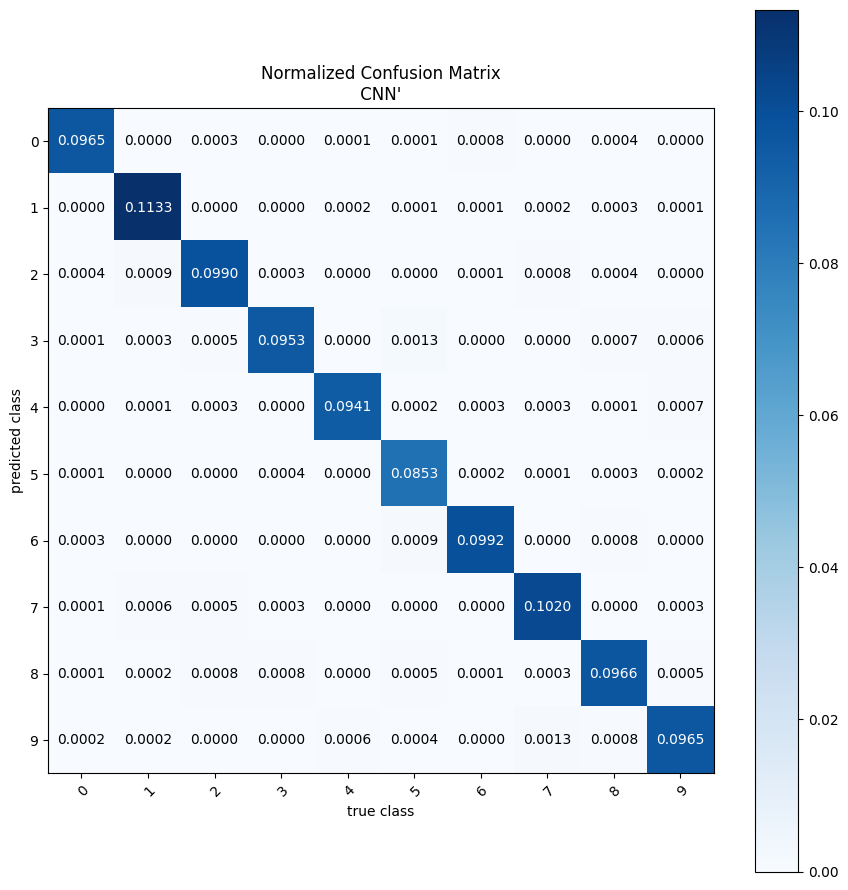

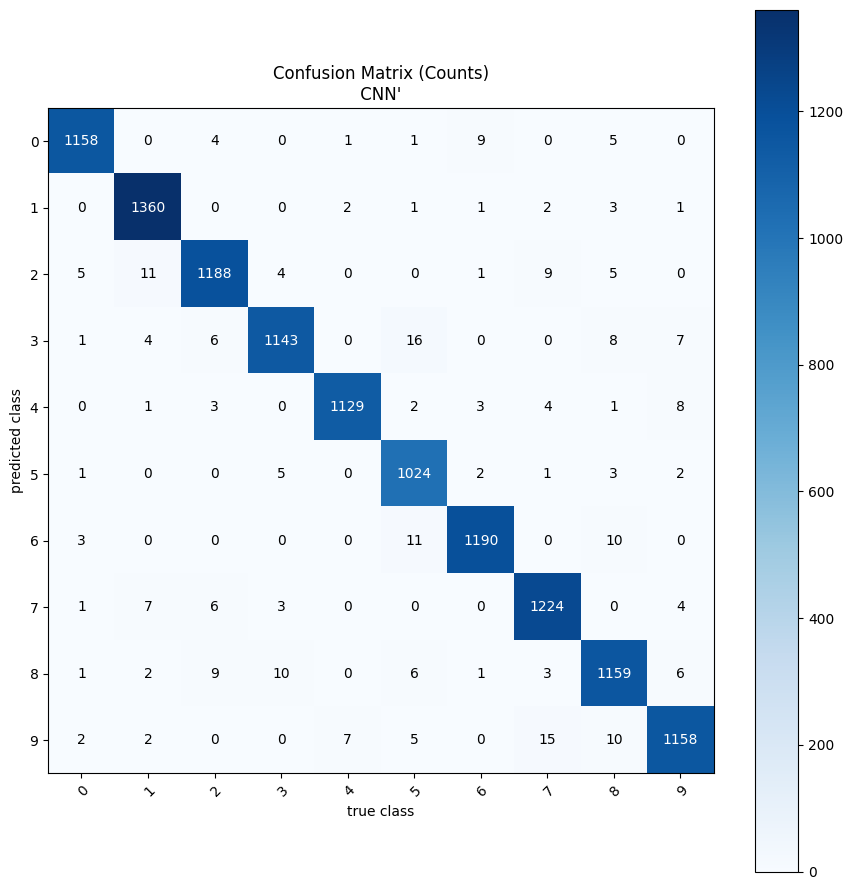

In [16]:
cnn_model = CnnModel(cuda=False, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200,20),
        nn_optimiser_params=nn_optimiser_params) \
    .with_name("CNN'") \
    .with_input_tensoriser(ImageReshapingInputTensoriser())

eval_data = eval_util.perform_simple_evaluation(cnn_model)

Our CNN models do improve upon the MLP model we evaluated earlier. Let's do a comparison of all the models we trained thus far:

INFO  2024-06-11 09:33:03,359 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 1/4 named 'MLP' ...


DEBUG 2024-06-11 09:33:03,576 sensai.evaluation.evaluator:__init__:182 - <sensai.data.DataSplitterFractional object at 0x7fe227050750> created split with 48000 (80.00%) and 12000 (20.00%) training and test data points respectively


INFO  2024-06-11 09:33:03,577 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating MultiLayerPerceptronVectorClassificationModel[hidden_dims=(50, 20), hid_activation_function=<built-in method sigmoid of type object at 0x7fe1c8188880>, output_activation_function=ActivationFunction.LOG_SOFTMAX, input_dim=None, cuda=False, p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=Method[_create_torch_model], normalisationMode=NormalisationMode.MAX_ALL, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=54, optimiser_lr=0.001, shrinkage_clip=10.0, optimiser=adam, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=2, shuffle=True], model=MultiLayerPerceptronTorchModel[cuda=False, inputDim=784, outputDim=10, hidActivationFunction=<built-in method sigmoid of type object at 0x7fe1c8188880

DEBUG 2024-06-11 09:33:03,578 sensai.torch.torch_data:__init__:546 - Applying <sensai.torch.torch_data.TensoriserDataFrameFloatValuesMatrix object at 0x7fe2237009d0> to data frame of length 12000 ...


INFO  2024-06-11 09:33:03,706 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.96225, balancedAccuracy=0.9618968610010363, N=12000]


INFO  2024-06-11 09:33:04,111 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 2/4 named 'CNN' ...


INFO  2024-06-11 09:33:04,113 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating TorchVectorClassificationModel[featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=<sensai.torch.torch_base.TorchModelFactoryFromModule object at 0x7fe224909610>, normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFunction.NLL], optimiser_args={}, use_shrinkage=True, early_stopping_epochs=3, shuffle=True], model=TorchModelFromModule[cuda=False, bestEpoch=6, totalEpochs=9], inputTensoriser=<__main__.ImageReshapingInputTensoriser object at 0x7fe223249450>, outputTensoriser=None, torchDataSetProviderFactory=None, dataFrameSplitter=None, name=CNN] via <sensai.evaluation.evaluator.VectorClassificationModelEvaluator object at

DEBUG 2024-06-11 09:33:04,115 sensai.torch.torch_data:__init__:546 - Applying <__main__.ImageReshapingInputTensoriser object at 0x7fe223249450> to data frame of length 12000 ...


INFO  2024-06-11 09:33:05,909 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.9784166666666667, balancedAccuracy=0.9782716826784611, N=12000]


INFO  2024-06-11 09:33:06,226 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 3/4 named 'CNN'' ...


INFO  2024-06-11 09:33:06,227 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating CnnModel[cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=functools.partial(<class '__main__.CnnModel.VectorTorchModel'>, CnnModel[id=140609229841488, cuda=False, output_activation_fn=ActivationFunction.LOG_SOFTMAX, kernel_size=5, num_conv=32, pooling_kernel_size=2, mlp_hidden_dims=(200, 20), p_dropout=0.0, featureGenerator=None, outputMode=ClassificationOutputMode.LOG_PROBABILITIES, torch_model_factory=..., normalisationMode=NormalisationMode.NONE, nnOptimiserParams=NNOptimiserParams[epochs=1000, batch_size=1024, optimiser_lr=0.01, shrinkage_clip=10.0, optimiser=Optimiser.ADAMW, gpu=None, train_fraction=0.75, scaled_outputs=False, loss_evaluator=NNLossEvaluatorClassification[LossFun

DEBUG 2024-06-11 09:33:06,228 sensai.torch.torch_data:__init__:546 - Applying <__main__.ImageReshapingInputTensoriser object at 0x7fe223326ed0> to data frame of length 12000 ...


INFO  2024-06-11 09:33:08,024 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.97775, balancedAccuracy=0.9776402722798222, N=12000]


INFO  2024-06-11 09:33:08,353 sensai.evaluation.eval_util:compare_models:393 - Evaluating model 4/4 named 'RandomForest' ...


INFO  2024-06-11 09:33:08,355 sensai.evaluation.eval_util:perform_simple_evaluation:281 - Evaluating SkLearnRandomForestVectorClassificationModel[featureGenerator=None, fitArgs={}, useBalancedClassWeights=False, useLabelEncoding=False, name=RandomForest, model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False)] via <sensai.evaluation.evaluator.VectorClassificationModelEvaluator object at 0x7fe223777150>


INFO  2024-06-11 09:33:08,451 sensai.evaluation.eval_util:gather_results:289 - Evaluation results for label: ClassificationEvalStats[accuracy=0.9466666666666667, balancedAccuracy=0.945916926388699, N=12000]


INFO  2024-06-11 09:33:08,775 sensai.evaluation.eval_util:compare_models:462 - Model comparison results:
              accuracy  balancedAccuracy
model_name                              
MLP           0.962250          0.961897
CNN           0.978417          0.978272
CNN'          0.977750          0.977640
RandomForest  0.946667          0.945917


,accuracy,balancedAccuracy
model_name,,
MLP,0.962250,0.961897
CNN,0.978417,0.978272
CNN',0.977750,0.977640
RandomForest,0.946667,0.945917


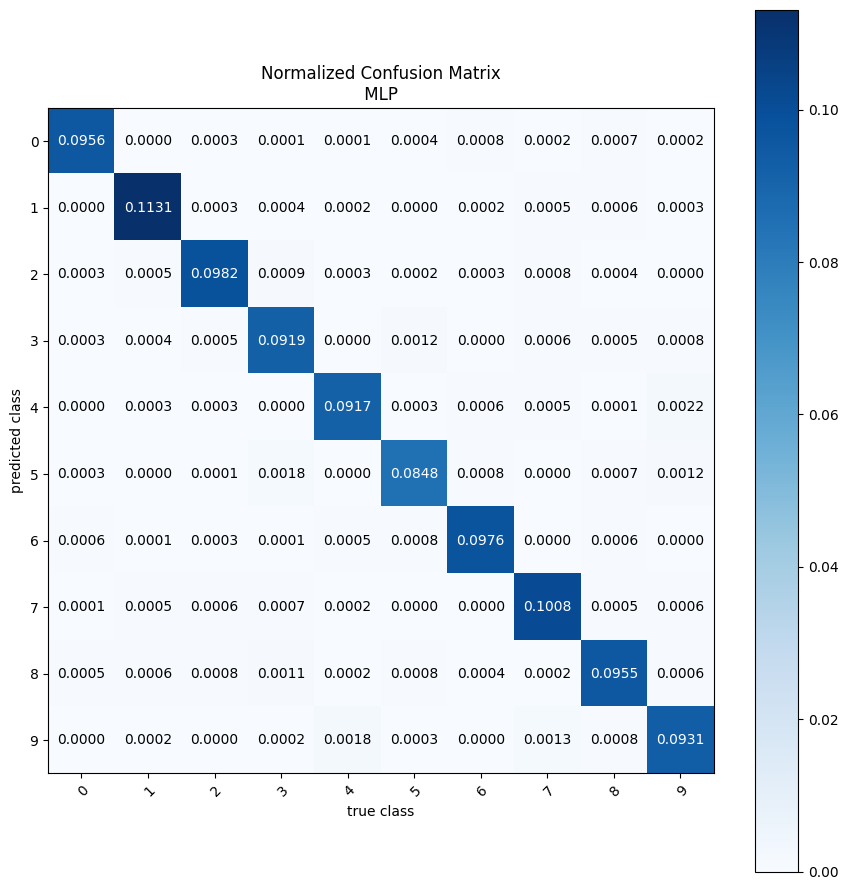

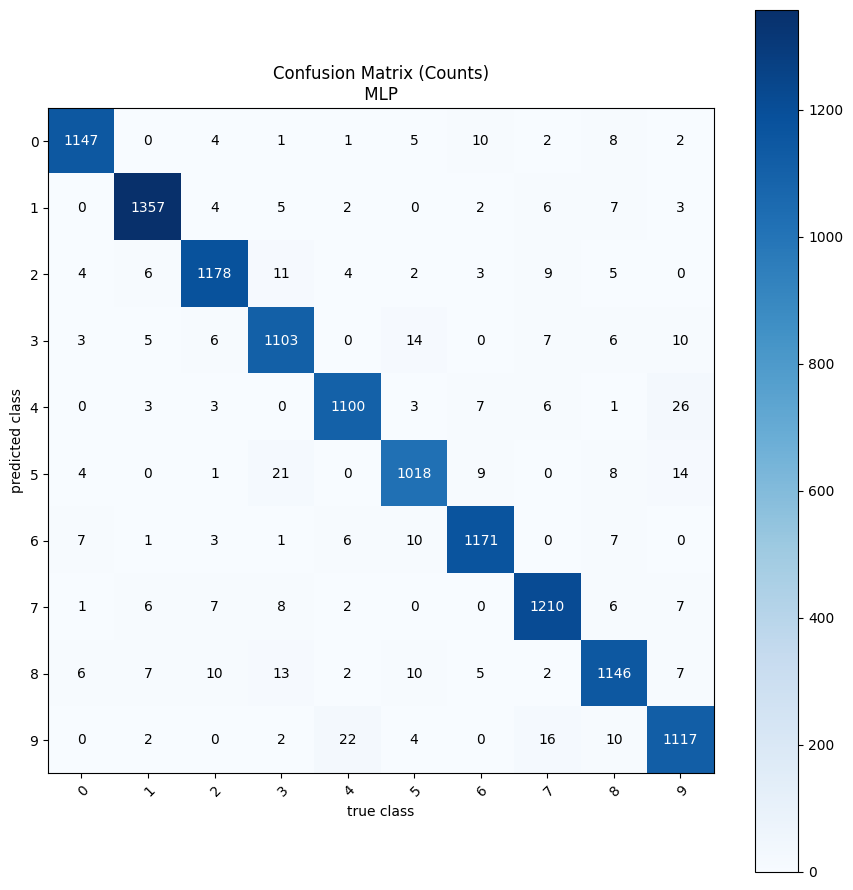

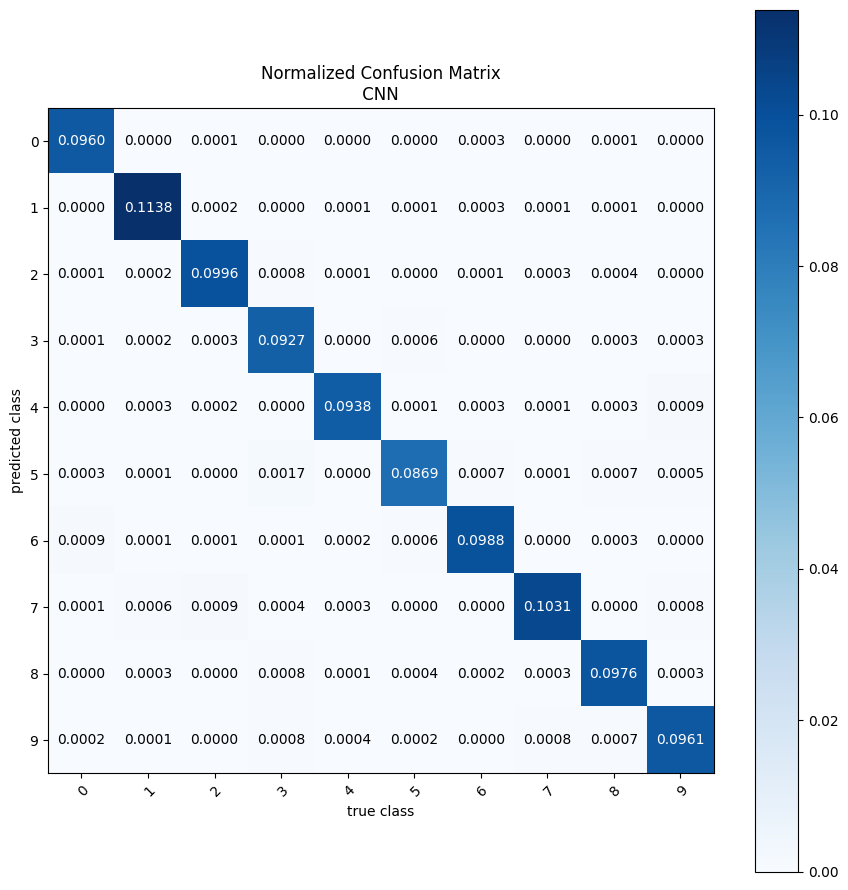

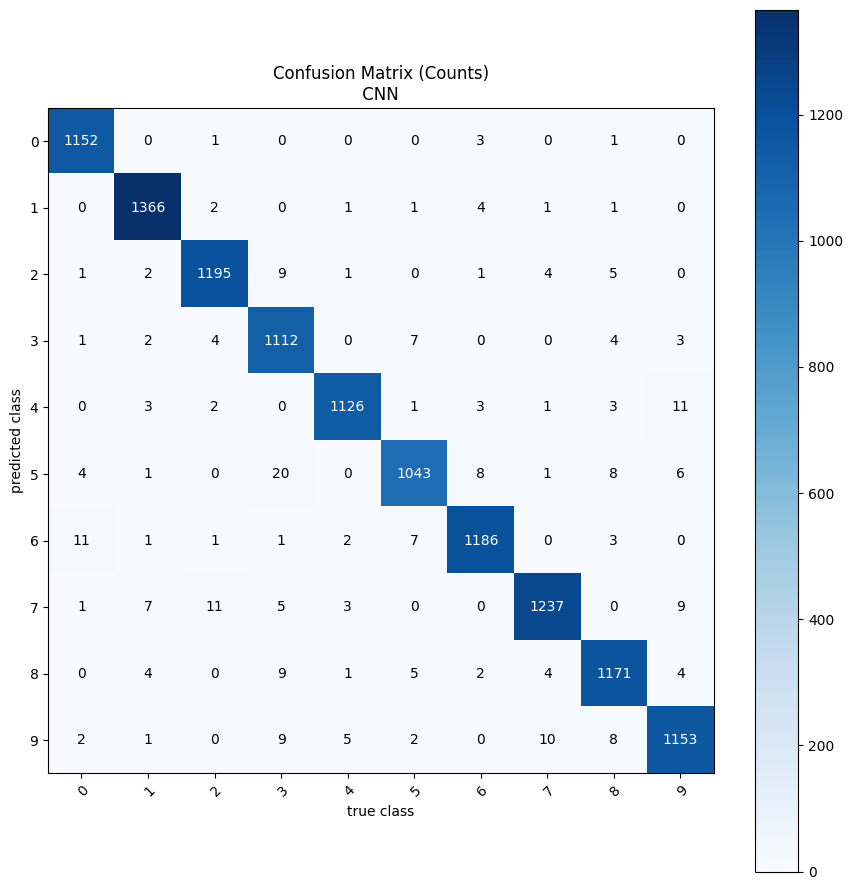

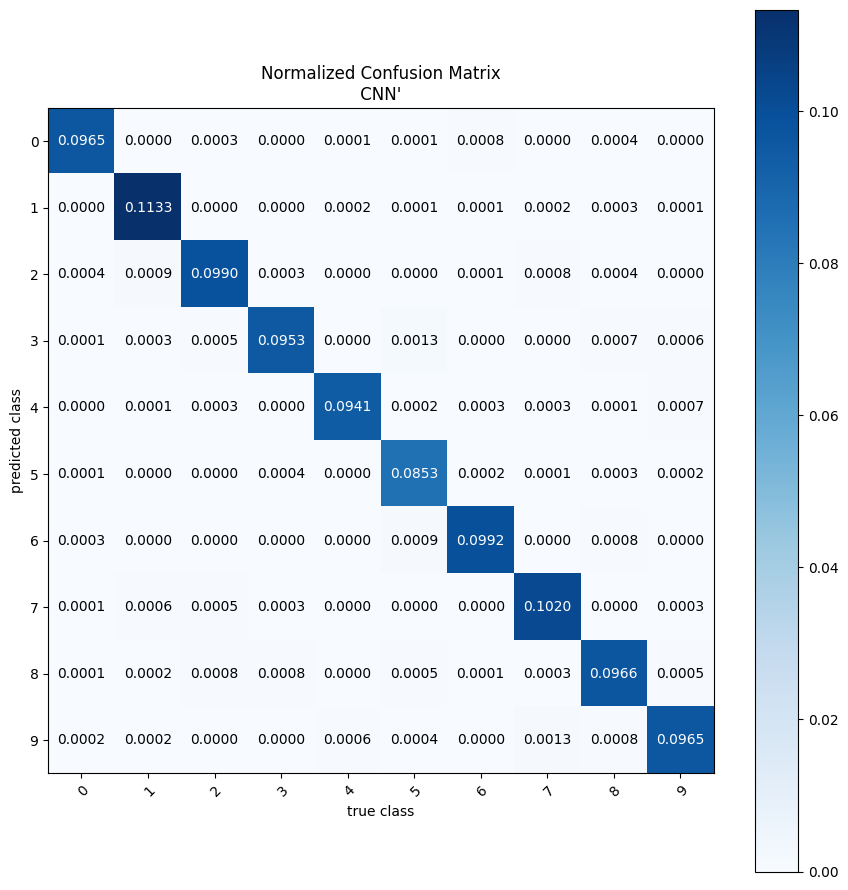

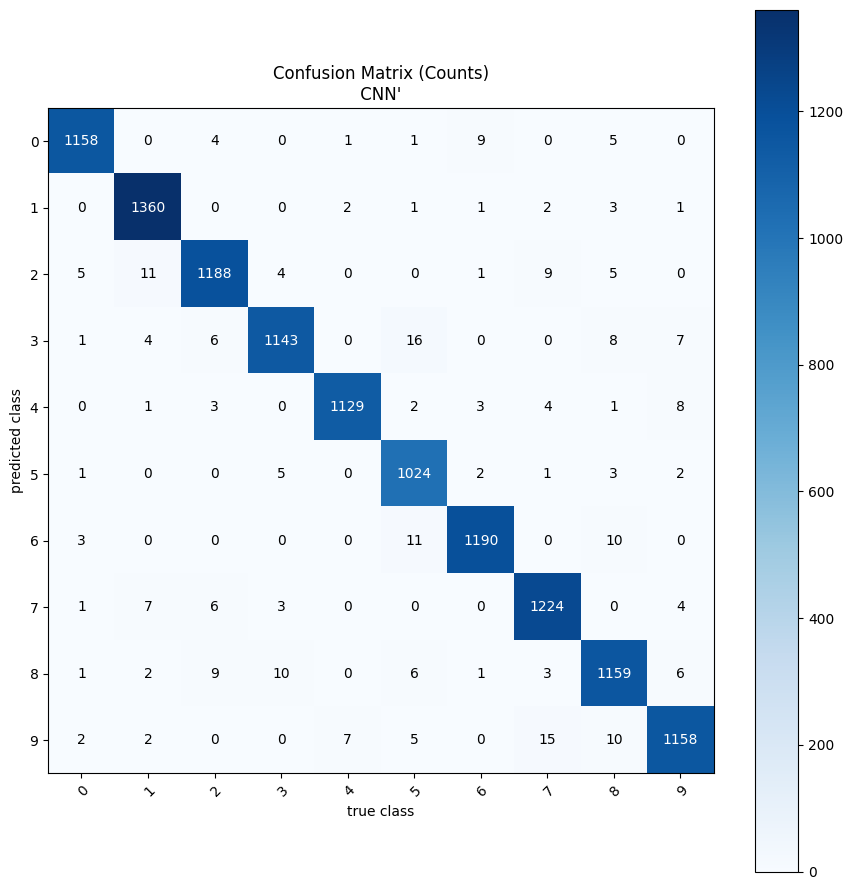

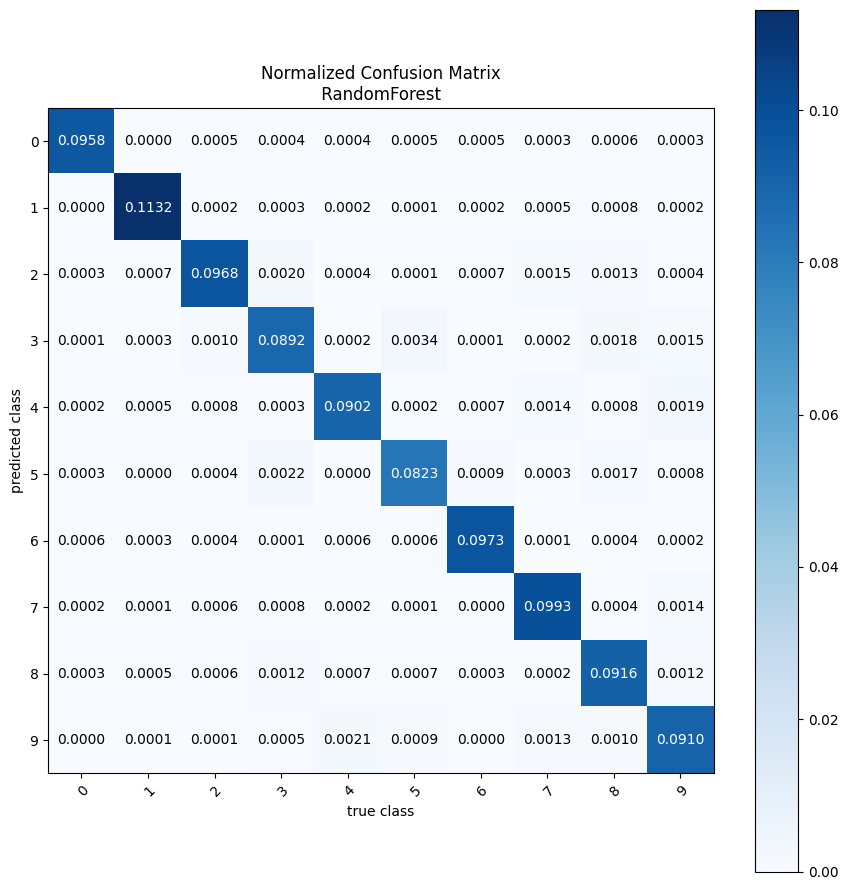

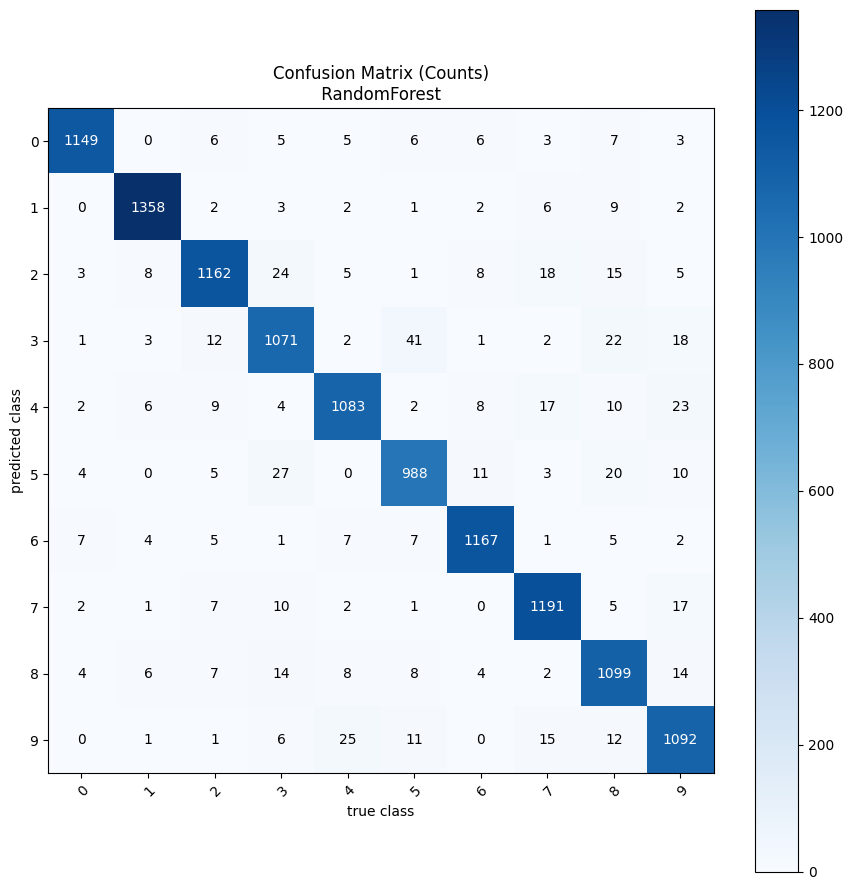

In [17]:
comparison_data = eval_util.compare_models([torch_mlp_model, cnn_model_from_module, cnn_model, random_forest_model], fit_models=False)
comparison_data.results_df

Note that any differences between the two CNN models are due only to randomness in the parameter initialisation; they are functionally identical.

Could the CNN model have produced even better results? Let's take a look at some examples where the CNN model went wrong by inspecting the evaluation data that was returned earlier.

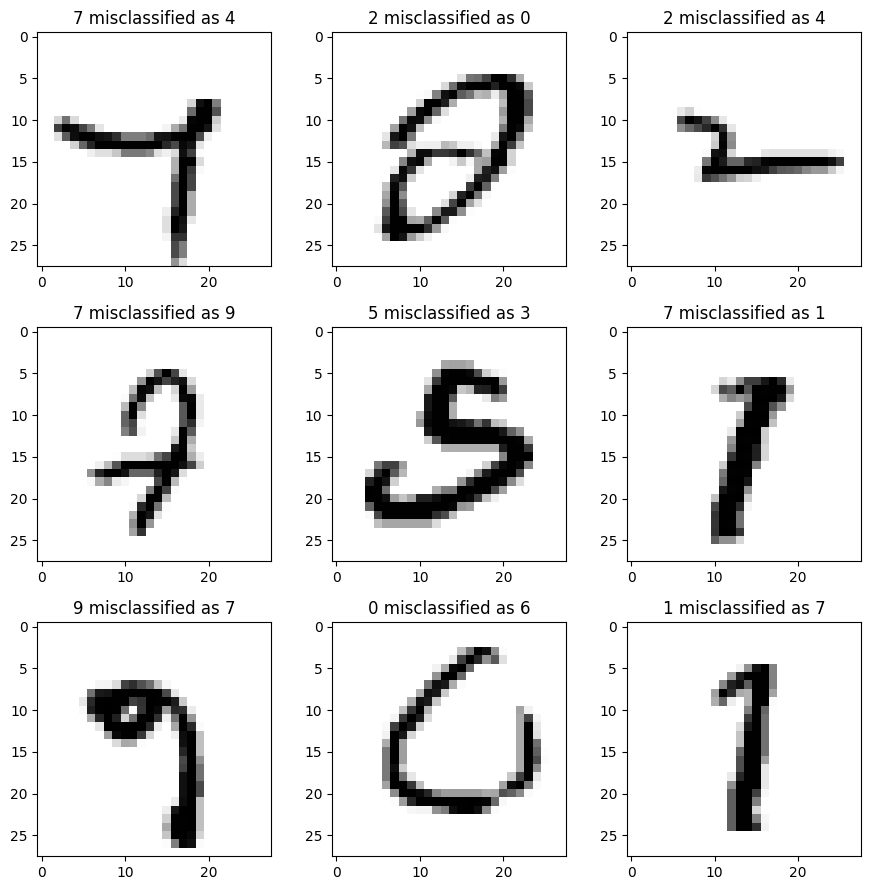

In [18]:
misclassified = eval_data.get_misclassified_triples_pred_true_input()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
for i, (predClass, trueClass, input) in enumerate(misclassified[:9]):
    axs[i//3][i%3].imshow(reshape_2d_image(input), cmap="binary")
    axs[i//3][i%3].set_title(f"{trueClass} misclassified as {predClass}")
plt.tight_layout()

While some of these examples are indeed ambiguous, there still is room for improvement.